In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import math

import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from pymongo import MongoClient
import json
from wordcloud import WordCloud

In [2]:
con = MongoClient('localhost',27017)
db = con.politica

In [3]:
dataset = pd.DataFrame()

In [4]:
text_tweets = []
for tweet in db.tweets_manuela.find():
    twitterText = ""
    if('retweeted_status' in tweet):
        if('extended_tweet' in tweet['retweeted_status']):
            twitterText = tweet['retweeted_status']['extended_tweet']['full_text']
        else:
            twitterText = tweet['retweeted_status']['text']

    elif('extended_tweet' in tweet):
        twitterText = tweet['extended_tweet']['full_text']
    else:
        twitterText = tweet['text']
    
    text_tweets.append(twitterText)

dataset['text'] = pd.Series(text_tweets)

In [5]:
dataset['text_processed'] = np.nan # coluna que guardará os tweets processados

In [31]:
# download do pacote de preprocessamente para língua portuguesa
#nltk.download('rslp')

In [6]:
#Preprocessar as palavras
stemmer = nltk.stem.RSLPStemmer()
for ind, tweet in enumerate(dataset['text']):
    t = tweet
    t = t.lower() # removendo letras maiúsculas
    t = re.sub(r'(\b)?@\w+','',t) #removendo referências a outros perfis
    t = re.sub(r'(\b)?#\w+','',t) #removendo hashtags
    t = re.sub(r'http\S+','',t,flags=re.MULTILINE) #removendo links
    t = re.sub(r'https\S+','',t,flags=re.MULTILINE) #removendo links
    t = re.sub(r'(\w+)?\d(\w+)?','',t) # removendo números
    t = re.sub(r',|\"|!|\n|:|\.|\?|;|\(|\)|#',' ',t) #removendo pontuações
    
    # removendo stopwords
    nsw = ''
    for word in t.split(' '):
        if word not in stopwords.words('portuguese'):
            nsw += word+' '
    t = nsw.strip()
    t = re.sub(r' +',' ',t) # removendo espaços duplos
    t = t.strip() # remover espaços vazios no início e no fim
    
    # isolando o radical das palavras
    if len(t) > 0:
        t = t.split(' ')
        ste = [stemmer.stem(word) for word in t]
        processedTweet = ' '.join(ste)
        dataset['text_processed'][ind] = processedTweet
    else:
        dataset['text_processed'][ind] = ''

/home/alysson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/alysson/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
#Objetos para vetorizar e calcular as frequencias das palavras
count_vect = CountVectorizer()
tfidf = TfidfTransformer()

In [8]:
#Indexando as palavras do corpos
matrix_vectorized = count_vect.fit_transform(dataset['text_processed'].values.tolist())
matrix_vectorized.shape

(3773, 3287)

In [9]:
#Features da matrix
count_vect.get_feature_names()[0:10]

['aaa',
 'aaaaaaa',
 'aaaaaaaaaaaqaaaaaaaaaaqqqqqadhehsbhejajansbndnd',
 'aaaaaaaag',
 'ab',
 'abaix',
 'abandon',
 'abert',
 'abig',
 'abobr']

In [20]:
#Calculando o TF e o IDF das palavras de cada tweet
matrix_tfidf = tfidf.fit_transform(matrix_vectorized)

In [21]:
matrix_tfidf.shape

(3773, 3287)

## Clusterização com DBSCAN

In [11]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import DBSCAN

**Observação:** Realizar a clusterização apenas com distância euclidiana

In [10]:
# matrix_distances = cosine_distances(matrix_tfidf)
# matrix_distances_cosine = cosine_distances(matrix_vectorized) #computando distâncias representação vetorial sem tf-idf
# matrix_distances_cosine.shape

(3773, 3773)

In [12]:
# matrix_distances_euclidean = euclidean_distances(matrix_tfidf)
matrix_distances_euclidean = euclidean_distances(matrix_vectorized) #computando distâncias representação vetorial sem tf-idf
matrix_distances_euclidean.shape

(3773, 3773)

In [13]:
# print("Distância cosseno, máximo: ",matrix_distances_cosine.max())
# print("Distância cosseno, média: ",matrix_distances_cosine.mean())
# print("Distância cosseno, std: ",matrix_distances_cosine.std())
# print("Distância cosseno, mínimo: ",matrix_distances_cosine.max())
# print("-----------------------------------")
print("Distância euclidiana, máximo: ",matrix_distances_euclidean.max())
print("Distância euclidiana, média: ",matrix_distances_euclidean.mean())
print("Distância euclidiana, std: ",matrix_distances_euclidean.std())
print("Distância euclidiana, mínimo: ",matrix_distances_euclidean.std())

Distância euclidiana, máximo:  19.390719429665317
Distância euclidiana, média:  4.550658562538737
Distância euclidiana, std:  1.5486174686388592
Distância euclidiana, mínimo:  1.5486174686388592


#### Para determinar Eps e MinPoints ideais vamos utilizar as seguintes abordagens:
1. [A Dynamic Method for Discovering Density Varied Clusters](http://www.sersc.org/journals/IJSIP/vol6_no1/9.pdf)


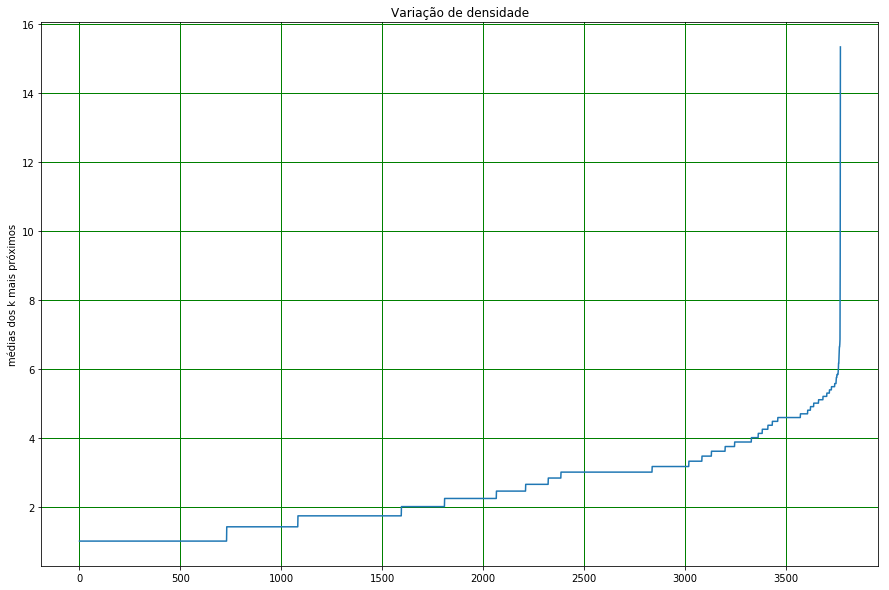

In [108]:
# ABORDAGEM 1
def k_dist(k, i, points):
    dist = []
    smaller = np.max(points)
    for i in range(0,k):
        for j in range(len(points)):
            if j != i:
                if points[j] < smaller and points[j] != 0:
                    smaller = points[j]
        dist.append(smaller)
    return np.mean(dist)

i = 0
y = []
while i < len(matrix_distances_euclidean):
    y.append(k_dist(3,i,matrix_distances_euclidean[i]))
    i += 1
y.sort()
    
plt.figure(figsize=(15,10))
plt.plot(y)
plt.grid(color='g', linestyle='-', linewidth=1)
plt.ylabel('médias dos k mais próximos')
plt.title('Variação de densidade')
plt.show()

In [14]:
# dbscan_cosine_distance = DBSCAN(eps=0.8, min_samples=30, metric="precomputed")
# clusters_cosine_dbscan = dbscan_cosine_distance.fit(matrix_distances_cosine)

minPoints = math.log(len(matrix_distances_euclidean))
dbscan_euclidean_distance = DBSCAN(eps=4.550658562538737, min_samples= minPoints, metric="precomputed")
clusters_euclidean_dbscan = dbscan_euclidean_distance.fit(matrix_distances_euclidean)

### Grid Search para Eps e MinPoints

In [65]:
eps = [4.0,4.1,4.2,4.3,4.4,4.5,4.6,4.7,4.8,4.9,5.0,5.1,5.2,5.3,5.4,5.5,5.6,5.7,5.8,5.9,6.0]
minpoints = range(8,24)

for e in eps:
    for m in minpoints:
        dbscan_euclidean_distance = DBSCAN(eps= e, min_samples= m, metric="precomputed")
        clusters_euclidean_dbscan = dbscan_euclidean_distance.fit(matrix_distances_euclidean)
        
        if len(dataset['cluster_euclidean_dbscan'].value_counts()) >= 3:
            print('eps=',e,', minpoints=',m)

            #atribuindo identificador dos clusters
            dataset['cluster_euclidean_dbscan'] = clusters_euclidean_dbscan.labels_

            #polaridade dos clusters
            print(dataset.groupby('cluster_euclidean_dbscan')['polaridade'].sum())
            print('-------------------------------------------------')

eps= 4.0 , minpoints= 8
cluster_euclidean_dbscan
-1    -548.0
 0   -1515.0
 1   -3843.0
 2     -60.0
 3    -450.0
 4     -98.0
Name: polaridade, dtype: float64
-------------------------------------------------
eps= 4.0 , minpoints= 9
cluster_euclidean_dbscan
-1    -548.0
 0   -1515.0
 1   -3843.0
 2     -60.0
 3    -450.0
 4     -98.0
Name: polaridade, dtype: float64
-------------------------------------------------
eps= 4.0 , minpoints= 10
cluster_euclidean_dbscan
-1    -548.0
 0   -1515.0
 1   -3843.0
 2     -60.0
 3    -450.0
 4     -98.0
Name: polaridade, dtype: float64
-------------------------------------------------
eps= 4.0 , minpoints= 11
cluster_euclidean_dbscan
-1    -548.0
 0   -1515.0
 1   -3843.0
 2     -60.0
 3    -450.0
 4     -98.0
Name: polaridade, dtype: float64
-------------------------------------------------
eps= 4.0 , minpoints= 12
cluster_euclidean_dbscan
-1    -548.0
 0   -1515.0
 1   -3843.0
 2     -60.0
 3    -450.0
 4     -98.0
Name: polaridade, dtype: float

eps= 4.2 , minpoints= 17
cluster_euclidean_dbscan
-1    -599.0
 0   -1515.0
 1   -3890.0
 2     -60.0
 3    -450.0
Name: polaridade, dtype: float64
-------------------------------------------------
eps= 4.2 , minpoints= 18
cluster_euclidean_dbscan
-1    -599.0
 0   -1515.0
 1   -3890.0
 2     -60.0
 3    -450.0
Name: polaridade, dtype: float64
-------------------------------------------------
eps= 4.2 , minpoints= 19
cluster_euclidean_dbscan
-1    -599.0
 0   -1515.0
 1   -3890.0
 2     -60.0
 3    -450.0
Name: polaridade, dtype: float64
-------------------------------------------------
eps= 4.2 , minpoints= 20
cluster_euclidean_dbscan
-1    -599.0
 0   -1515.0
 1   -3890.0
 2     -60.0
 3    -450.0
Name: polaridade, dtype: float64
-------------------------------------------------
eps= 4.2 , minpoints= 21
cluster_euclidean_dbscan
-1    -659.0
 0   -1515.0
 1   -3890.0
 2    -450.0
Name: polaridade, dtype: float64
-------------------------------------------------
eps= 4.2 , minpoints= 2

eps= 4.5 , minpoints= 11
cluster_euclidean_dbscan
-1    -424.0
 0   -1515.0
 1   -3967.0
 2     -60.0
 3    -450.0
 4     -98.0
Name: polaridade, dtype: float64
-------------------------------------------------
eps= 4.5 , minpoints= 12
cluster_euclidean_dbscan
-1    -424.0
 0   -1515.0
 1   -3967.0
 2     -60.0
 3    -450.0
 4     -98.0
Name: polaridade, dtype: float64
-------------------------------------------------
eps= 4.5 , minpoints= 13
cluster_euclidean_dbscan
-1    -522.0
 0   -1515.0
 1   -3967.0
 2     -60.0
 3    -450.0
Name: polaridade, dtype: float64
-------------------------------------------------
eps= 4.5 , minpoints= 14
cluster_euclidean_dbscan
-1    -522.0
 0   -1515.0
 1   -3967.0
 2     -60.0
 3    -450.0
Name: polaridade, dtype: float64
-------------------------------------------------
eps= 4.5 , minpoints= 15
cluster_euclidean_dbscan
-1    -522.0
 0   -1515.0
 1   -3967.0
 2     -60.0
 3    -450.0
Name: polaridade, dtype: float64
----------------------------------

In [15]:
# dataset['cluster_cosine_dbscan'] = clusters_cosine_dbscan.labels_
dataset['cluster_euclidean_dbscan'] = clusters_euclidean_dbscan.labels_

In [16]:
dataset.head()

,text,text_processed,cluster_euclidean_dbscan
0,"A pergunta é séria, @manudeputada: quer me pag...",pergunt é sér qu pag log fic dev process senh ...,0
1,"@manudeputada @PCdoB_Oficial ""Malevolente amor...",malevol am é tud é redenç sorris humilh dren v...,1
2,"A pergunta é séria, @manudeputada: quer me pag...",pergunt é sér qu pag log fic dev process senh ...,0
3,Eu e a namo levemente apaixonadas pela deputad...,nam lev apaixon deput fal sal aul conheç favor,1
4,@JoselitoMuller3 @manudeputada hmm esse cabeli...,hmm cabel ócul falt dent frent parec nunc com ...,1


## Clusterização com K-means

In [17]:
#from sklearn.metrics.pairwise import cosine_distances
# from sklearn.metrics.pairwise import euclidean_distances
# from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

**Observação:** Realizar a clusterização apenas com as distâncias euclidianas

In [70]:
# matrix_distances = cosine_distances(matrix_tfidf)
# matrix_distances.shape

(3773, 3773)

In [18]:
# matrix_distances_euclidean = euclidean_distances(matrix_tfidf)
# matrix_distances_euclidean = euclidean_distances(matrix_vectorized) #computando distâncias representação vetorial sem tf-idf
# matrix_distances_euclidean.shape

kmeans_euclidean_distance = MiniBatchKMeans(n_clusters=3)
clusters_euclidean_kmeans = kmeans_euclidean_distance.fit(matrix_vectorized)
dataset['cluster_euclidean_kmeans'] = clusters_euclidean_kmeans.labels_

In [46]:
# kmeans_cosine_distance = KMeans(n_clusters=3, precompute_distances=True)
# clusters_cosine_kmeans = kmeans_cosine_distance.fit(matrix_distances)

kmeans_euclidean_distance = KMeans(n_clusters=3, precompute_distances=True)
clusters_euclidean_kmeans = kmeans_euclidean_distance.fit(matrix_distances_euclidean)

In [47]:
# dataset['cluster_cosine_kmeans'] = clusters_cosine_kmeans.labels_
dataset['cluster_euclidean_kmeans'] = clusters_euclidean_kmeans.labels_

## Plot dos clusters do DBScan

In [48]:
import matplotlib.pyplot as plt

In [65]:
dataset['cluster_cosine_dbscan'].value_counts()

0    3773
Name: cluster_cosine_dbscan, dtype: int64

In [19]:
dataset['cluster_euclidean_dbscan'].value_counts()

 1    3150
 0     303
-1     213
 3      75
 2      20
 4      12
Name: cluster_euclidean_dbscan, dtype: int64

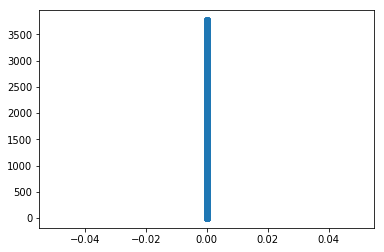

In [67]:
x = dataset['cluster_cosine_dbscan'].values
y = range(len(dataset['text'].values))
plt.plot(x, y, "o")
plt.show()

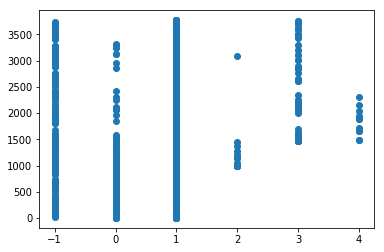

In [17]:
x = dataset['cluster_euclidean_dbscan'].values
y = range(len(dataset['text'].values))
plt.plot(x, y, "o")
plt.show()

## Plot dos clusters do KMeans

In [49]:
dataset['cluster_cosine_kmeans'].value_counts()

1    3135
2     335
0     303
Name: cluster_cosine_kmeans, dtype: int64

In [20]:
dataset['cluster_euclidean_kmeans'].value_counts()

1    3174
2     303
0     296
Name: cluster_euclidean_kmeans, dtype: int64

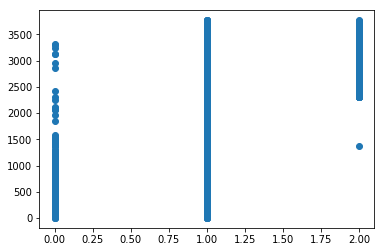

In [51]:
x = dataset['cluster_cosine_kmeans'].values
y = range(len(dataset['text'].values))
plt.plot(x, y, "o")
plt.show()

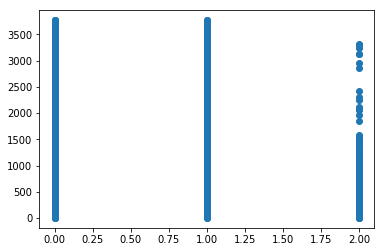

In [52]:
x = dataset['cluster_euclidean_kmeans'].values
y = range(len(dataset['text'].values))
plt.plot(x, y, "o")
plt.show()

* ## Avaliando Clusterização

In [21]:
#Sum-of-Squared-Error
kmeans_euclidean_distance.inertia_

31198.950726303137

In [22]:
#Silhouette Value
from sklearn.metrics import silhouette_score

silhouette_score(X=matrix_distances_euclidean,labels=kmeans_euclidean_distance.labels_)

0.5080311315709207

In [23]:
silhouette_score(X=matrix_distances_euclidean,labels=dbscan_euclidean_distance.labels_)

0.355489485472013

## Calculando polaridade dos tweets

In [39]:
base_lexica = pd.read_csv('../SEMANTICSCLASSIFICATION/SentiLex-PT01/SentiLex-flex-PT01.txt', sep=';')
base_lexica.columns = ['palavra','gn','tg','pol','anot']

In [40]:
base_lexica['pos'] = np.nan

In [41]:
i = 0
for p in base_lexica.palavra:
    line = p.split('.')
    base_lexica.palavra[i] = line[0]
    base_lexica.pos[i] = line[1]
    i += 1

/home/alysson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/alysson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/alysson/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [42]:
dataset['polaridade'] = 0

In [43]:
base_lexica.head()

,palavra,gn,tg,pol,anot,pos
0,"abafadas,abafado",GN=fp,TG=HUM,POL=-1,ANOT=JALC,PoS=Adj
1,"abafado,abafado",GN=ms,TG=HUM,POL=-1,ANOT=JALC,PoS=Adj
2,"abafados,abafado",GN=mp,TG=HUM,POL=-1,ANOT=JALC,PoS=Adj
3,"abafante,abafante",GN=fs,TG=HUM,POL=-1,ANOT=MAN,PoS=Adj
4,"abafante,abafante",GN=ms,TG=HUM,POL=-1,ANOT=MAN,PoS=Adj


In [44]:
def preProcessor(tweet):
    t = tweet
    t = t.lower() # removendo letras maiúsculas
    t = re.sub(r'(\b)?@\w+','',t) #removendo referências a outros perfis
#     t = re.sub(r'(\b)?#\w+','',t) #removendo hashtags
    t = re.sub(r'http\S+','',t,flags=re.MULTILINE) #removendo links
    t = re.sub(r'https\S+','',t,flags=re.MULTILINE) #removendo links
    t = re.sub(r'(\w+)?\d(\w+)?','',t) # removendo números
    t = re.sub(r',|\"|!|\n|:|\.|\?|;|\(|\)',' ',t) #removendo pontuações
    
    # removendo stopwords
    nsw = ''
    for word in t.split(' '):
        if word not in stopwords.words('portuguese'):
            nsw += word+' '
    t = nsw.strip()
    
    t = re.sub(r' +',' ',t) # removendo espaços duplos
    t = t.strip() # remover espaços vazios no início e no fim
    return t

In [45]:
def searchWord(word):
    k = 0
    for p in base_lexica.palavra:
        if word in p:
            return int(base_lexica.pol[k].split('=')[1])
        k += 1
    return 0

In [46]:
j = 0
for tweet in dataset.text:
    twt = preProcessor(tweet)
    score = 0
    for p in twt.split(' '):
        score += searchWord(p)
    dataset.polaridade[j] = score
    j += 1

/home/alysson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [38]:
dataset.to_csv('manuela_clusterizado.csv',';',encoding='utf-8', index=False)

## Análise dos clusters do DBScan

In [35]:
df = pd.read_csv('../SEMANTICSCLASSIFICATION/SentiLex.csv',sep=';',encoding='utf-8')

In [47]:
dataset['polaridade'] = datasetmanuela_clusterizado.csv.polaridade

In [48]:
dataset.head()

,text,text_processed,cluster_euclidean_dbscan,cluster_euclidean_kmeans,polaridade
0,"A pergunta é séria, @manudeputada: quer me pag...",pergunt é sér qu pag log fic dev process senh ...,0,2,-5
1,"@manudeputada @PCdoB_Oficial ""Malevolente amor...",malevol am é tud é redenç sorris humilh dren v...,1,1,-3
2,"A pergunta é séria, @manudeputada: quer me pag...",pergunt é sér qu pag log fic dev process senh ...,0,2,-5
3,Eu e a namo levemente apaixonadas pela deputad...,nam lev apaixon deput fal sal aul conheç favor,1,1,-1
4,@JoselitoMuller3 @manudeputada hmm esse cabeli...,hmm cabel ócul falt dent frent parec nunc com ...,1,1,2


In [69]:
dataset.groupby('cluster_cosine_dbscan')['polaridade'].sum()

cluster_cosine_dbscan
0   -6509.0
Name: polaridade, dtype: float64

In [49]:
dataset.groupby('cluster_euclidean_dbscan')['polaridade'].sum()

cluster_euclidean_dbscan
-1    -445
 0   -1515
 1   -3920
 2     -60
 3    -450
 4     -98
Name: polaridade, dtype: int64

In [50]:
dbscan_pos,dbscan_neg,dbscan_neu = 0,0,0
clusters_dbscan = []
for i in range(-1,len(dataset.groupby('cluster_euclidean_dbscan'))-1):
    dbscan_pos,dbscan_neg,dbscan_neu = 0,0,0
    for v in dataset.polaridade[dataset.cluster_euclidean_dbscan[dataset.cluster_euclidean_dbscan == i].index].values:
        if v < 0:
            dbscan_neg += 1
        if v > 0:
            dbscan_pos += 1
        if v == 0:
            dbscan_neu += 1
    print('Cluster '+str(i))
    print('pos = ',str(dbscan_pos), '; neg = ',str(dbscan_neg), '; neu=',str(dbscan_neu))
    clusters_dbscan.append((dbscan_pos,dbscan_neg,dbscan_neu))

Cluster -1
pos =  36 ; neg =  147 ; neu= 30
Cluster 0
pos =  0 ; neg =  303 ; neu= 0
Cluster 1
pos =  422 ; neg =  2008 ; neu= 720
Cluster 2
pos =  0 ; neg =  20 ; neu= 0
Cluster 3
pos =  0 ; neg =  75 ; neu= 0
Cluster 4
pos =  0 ; neg =  12 ; neu= 0


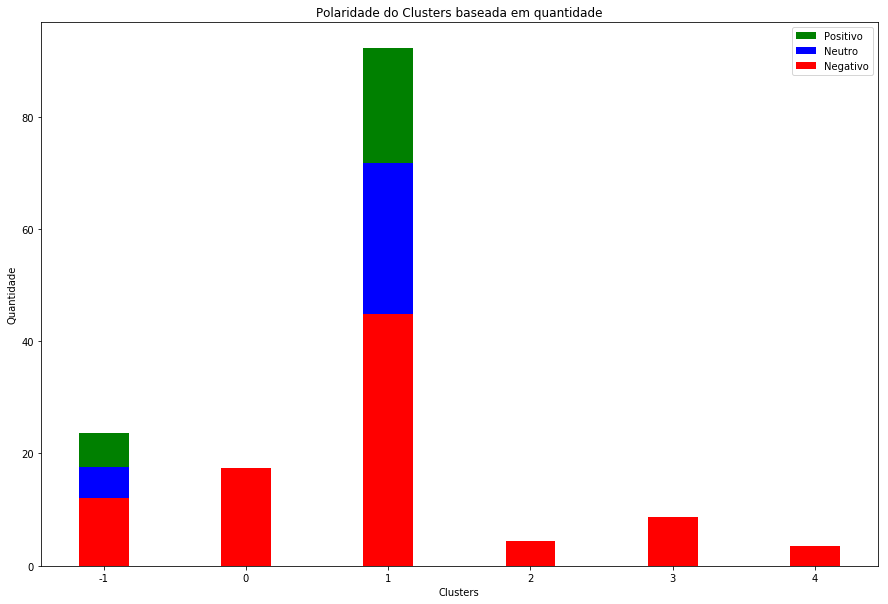

In [51]:
def normalize(t, i):
    return math.sqrt(t[i])

def labelCluster(i):
    return str(i)

# Gráfico de distribuição de polaridades

C = len(dataset.groupby('cluster_euclidean_dbscan'))
dbscan_pos = np.array([normalize(i,0) for i in clusters_dbscan])
dbscan_neg = np.array([normalize(i,1) for i in clusters_dbscan])
dbscan_neu = np.array([normalize(i,2) for i in clusters_dbscan])

ind = np.arange(C)
width = 0.35

plt.figure(figsize=(15,10))
pNeg = plt.bar(ind, dbscan_neg, width, color='r')
pNeu = plt.bar(ind, dbscan_neu, width, bottom=dbscan_neg, color='b')
pPos = plt.bar(ind, dbscan_pos, width, bottom=dbscan_neu+dbscan_neg, color='g')


plt.ylabel('Quantidade')
plt.xlabel('Clusters')
plt.title('Polaridade do Clusters baseada em quantidade')
plt.xticks(ind, tuple([labelCluster(i) for i in range(-1,C+1)]))
plt.legend((pPos[0], pNeu[0], pNeg[0]), ('Positivo', 'Neutro', 'Negativo'))

plt.show()

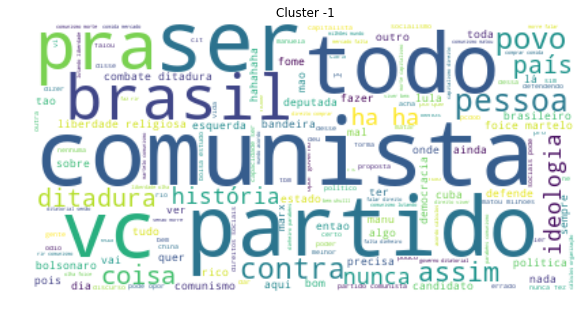

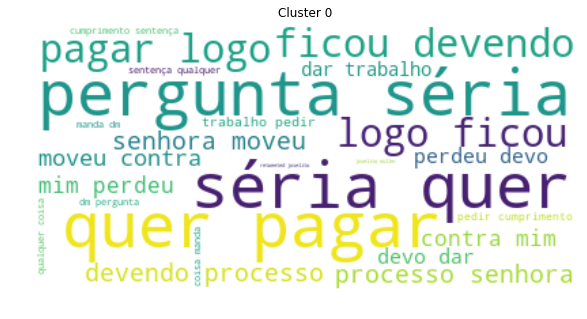

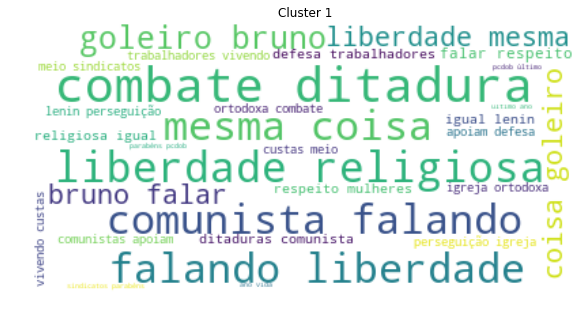

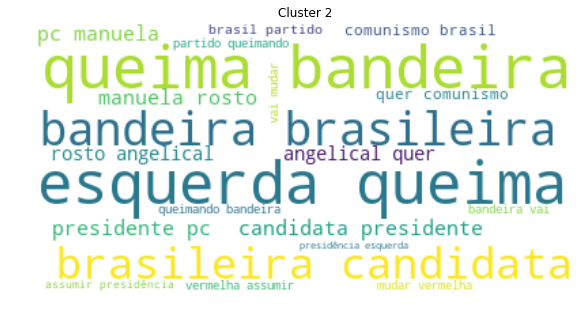

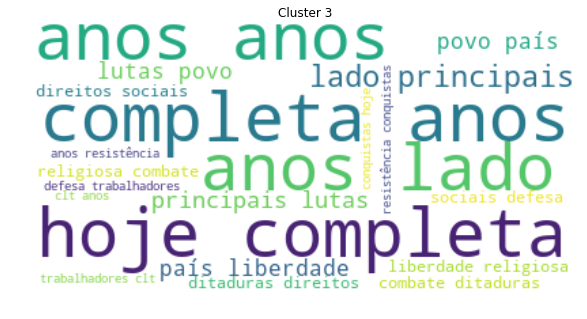

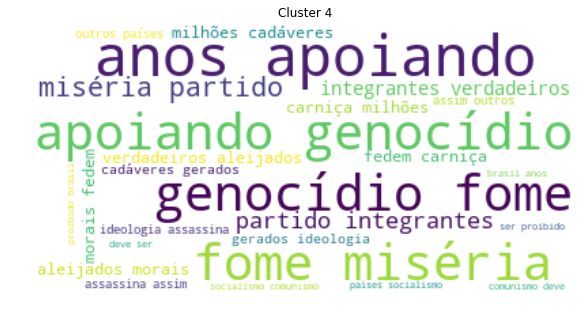

In [53]:
# Nuvem de palavras dos clustersfor i in count_clusters_dbscan:
from wordcloud import WordCloud

count_clusters_dbscan = dataset.cluster_euclidean_dbscan.value_counts().index.tolist()
count_clusters_dbscan.sort()

for i in count_clusters_dbscan:
    text = preProcessor(" ".join(dataset.text[dataset.cluster_euclidean_dbscan == i].tolist()))
    
    wordcloud = WordCloud(background_color='white', max_words=2500).generate(text)

    plt.figure(figsize=(10,5))
    plt.title('Cluster '+str(i))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

plt.show()

In [ ]:
dataset['polaridade'] = df.polaridade
dataset.groupby('cluster_cosine_kmeans')['polaridade'].sum()

In [54]:
dataset.groupby('cluster_euclidean_kmeans')['polaridade'].sum()

cluster_euclidean_kmeans
0   -1184
1   -3789
2   -1515
Name: polaridade, dtype: int64

In [55]:
kmeans_pos,kmeans_neg,kmeans_neu = 0,0,0
clusters_kmeans = []
for i in range(0,3):
    kmeans_pos,kmeans_neg,kmeans_neu = 0,0,0
    for v in dataset.polaridade[dataset.cluster_euclidean_kmeans[dataset.cluster_euclidean_kmeans == i].index].values:
        if v < 0:
            kmeans_neg += 1
        if v > 0:
            kmeans_pos = 0
neg = 0
neu = 0
#for v in dataset.polaridade[dataset.cluster_euclidean_kmeans[dataset.cluster_euclidean_kmeans == 2].index].values:
for v in dataset.polaridade.values:
    if v < 0:
        neg += 1
    if v > 0:
        pos += 1
    if v == 0:
        neu += 1

print(pos)
print(neg)
print(neu)pos += 1
        if v == 0:
            kmeans_neu += 1
    print('Cluster '+str(i))
    print('pos = ',str(kmeans_pos), '; neg = ',str(kmeans_neg), '; neu=',str(kmeans_neu))
    clusters_kmeans.append((kmeans_pos,kmeans_neg,kmeans_neu))

Cluster 0
pos =  0 ; neg =  296 ; neu= 0
Cluster 1
pos =  458 ; neg =  1966 ; neu= 750
Cluster 2
pos =  0 ; neg =  303 ; neu= 0


> #### K-means with only CountVectorized

Tipo de distância| Cluster 0| Cluster 1| Cluster2
-----------------|---------------|--------------|---------------
Distância cosseno|pos = 0; neg = 299; neu = 4| pos = 434; neg = 2049; neu = 649|pos = 24; neg = 241; neu = 70
Distância euclidiana|pos = 319; neg = 1397; neu = 560| pos = 139; neg = 893; neu = 159|pos = 0; neg = 299; neu = 4


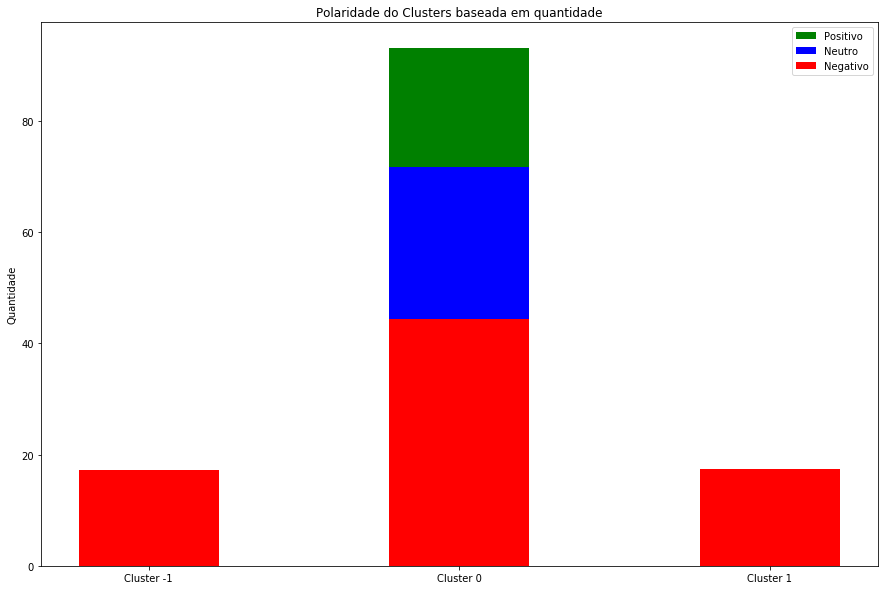

In [56]:
# Gráfico de distribuição de polaridades

C = 3
kmeans_pos = np.array([normalize(i,0) for i in clusters_kmeans])
kmeans_neg = np.array([normalize(i,1) for i in clusters_kmeans])
kmeans_neu = np.array([normalize(i,2) for i in clusters_kmeans])

ind = np.arange(C)
width = 0.45

plt.figure(figsize=(15,10))
pNeg = plt.bar(ind, kmeans_neg, width, color='r')
pNeu = plt.bar(ind, kmeans_neu, width, bottom=kmeans_neg, color='b')
pPos = plt.bar(ind, kmeans_pos, width, bottom=kmeans_neu+kmeans_neg, color='g')


plt.ylabel('Quantidade')
plt.title('Polaridade do Clusters baseada em quantidade')
plt.xticks(ind, ('Cluster -1', 'Cluster 0', 'Cluster 1', 'Cluster 2'))
plt.legend((pPos[0], pNeu[0], pNeg[0]), ('Positivo', 'Neutro', 'Negativo'))

plt.show()

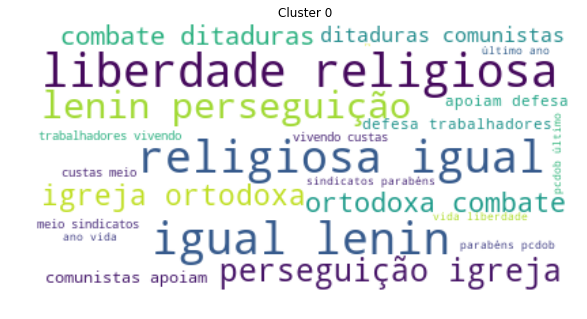

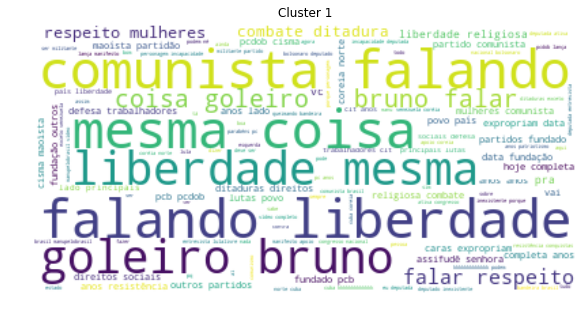

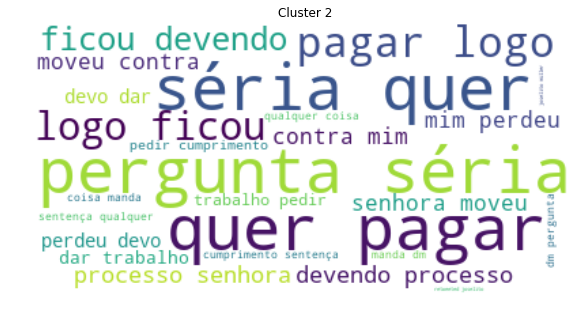

In [58]:
# Nuvem de palavras dos clusters
count_clusters_kmeans = dataset.cluster_euclidean_kmeans.value_counts().index.tolist()
count_clusters_kmeans.sort()

for i in count_clusters_kmeans:
    text = preProcessor(" ".join(dataset.text[dataset.cluster_euclidean_kmeans == i].tolist()))
    
    wordcloud = WordCloud(background_color='white', max_words=2500).generate(text)

    plt.figure(figsize=(10,5))
    plt.title('Cluster '+str(i))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

plt.show()

In [24]:
import SEMANTICSCLASSIFICATION.semanticsClassification as sc

In [7]:
sc.termScoreSummationMethod(df.text[7])

0

### Recalculando a polaridade

In [10]:
df['polaridade_sentilex'] = 0

In [12]:
i = 0
for tweet in df.text:
    df.polaridade_sentilex[i] = sc.termScoreSummationMethod(tweet)
    i += 1

/home/alysson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
df.polaridade_sentilex[df.polaridade_sentilex < 0]

Series([], Name: polaridade_sentilex, dtype: int64)

In [25]:
sc.termScoreSummationMethod("ruim horrível péssimo")

0

In [57]:
ifeel = pd.DataFrame()
ifeel['text'] = dataset.text[0:298]

j = 0
for i in ifeel.text:
    ifeel.text[j] = preProcessor(i)
    j += 1
    
ifeel.to_csv('ifeel_test.csv', sep=';',index=False)